# DS-GA 3001.001 Special Topics in Data Science: Probabilistic Time Series Analysis

# Week 4 EM

In [1]:
# Install PyKalman
# pip install pykalman
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.stats import multivariate_normal

# Data Visualiztion
def plot_kalman(x,y,nx,ny,kx=None,ky=None, plot_type="r-", label=None, title='Parabola'):
    """
    Plot the trajectory
    """
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    if kx is not None and ky is not None:
        ax[0].plot(x,y,'g-',nx,ny,'b.',kx,ky, plot_type)
        ax[0].plot(kx[0], ky[0], 'or')
        ax[0].plot(kx[-1], ky[-1], 'xr')
        
        ax[1].plot(x, kx, '.k', label='latent dim 1')
        ax[1].plot(y, ky, '.', color='grey', label='latent dim 2')
        ax[1].set_xlabel('real latent')
        ax[1].set_ylabel('estimated latent')
        ax[1].legend()
    else:
        ax[0].plot(x,y,'g-',nx,ny,'b.')
        
        ax[1].plot(x, nx, '.k', label='dim 1')
        ax[1].plot(y, ny, '.', color='grey', label='dim 2')
        ax[1].set_xlabel('latent')
        ax[1].set_ylabel('observed')
        ax[1].legend()

    ax[0].set_xlabel('X position')
    ax[0].set_ylabel('Y position')
    ax[0].set_title(title)
    ax[0].set_aspect(1)
    ax[1].set_aspect(1)
    
    if kx is not None and ky is not None and label is not None:
        ax[0].legend(('true','measured', label))
    else:
        ax[0].legend(('true','measured'))
    
    return fig
    
def visualize_line_plot(data, xlabel, ylabel, title):
    """
    Function that visualizes a line plot
    """
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
def print_parameters(kf_model, need_params=None, evals=False):
    """
    Function that prints out the parameters for a Kalman Filter
    @param - kf_model : the model object
    @param - need_params : a list of string
    """
    if evals:
        if need_params is None:
            need_params1 = ['transition_matrices', 'transition_covariance', 'observation_covariance', 'initial_state_covariance']
            need_params2 = ['observation_matrices', 'initial_state_mean']
        for param in need_params1: 
            tmp = np.linalg.eig(getattr(kf_model, param))[0]
            print("{0} = {1}, shape = {2}\n".format(param, tmp, tmp.shape))
        for param in need_params2: 
            print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))
    else:
        if need_params is None:
            need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance', 'observation_covariance', 
                            'initial_state_mean', 'initial_state_covariance']
        for param in need_params: 
            print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))
    

## Kalman

We want to infer the latent variable $z_n$ given the observed variable $x_n$.

$$P(z_n|x_1, ..., x_n, x_{n+1}, ..., x_N)\sim N(\hat{\mu_n}, \hat{V_n})$$

### Forward: Filtering
obtain estimates of latent by running the filtering from $n=0,....N$ 

#### prediction given latent space parameters
<br>
<img src='img/LDS_latent.svg', width = 110, height=90>


$$z_n^{pred}\sim N(\mu_n^{pred},V_n^{pred})$$

$$\mu_n^{pred}=A\mu_{n-1}$$

*this is the prediction for $z_n$ obtained simply by taking the expected value of $z_{n-1}$ and projecting it forward one step using the transition probability matrix $A$*

$$V_n^{pred}=AV_{n-1}A^T+\Gamma$$
*same for the covariance taking into account the noise covariance $\Gamma$*

#### correction (innovation) from observation
<br>
<img src='img/LDS_observed.svg', width = 40, height=80>

project to observational space:
$$x_n^{pred}\sim N(C\mu_n^{pred}, CV_n^{pred}C^T+\Sigma)$$

correct prediction by actual data:
$$z_n^{innov}\sim N(\mu_n^{innov}, V_n^{innov})$$

$$\mu_n^{innov}=\mu_n^{pred}+K_n(x_n-C\mu_n^{pred})$$

$$V_n^{innov}=(I-K_nC)V_n^{pred}$$

Kalman gain matrix: 
$$K_n=V_n^{pred}C^T(CV_n^{pred}C^T+\Sigma)^{-1}$$

*we use the latent-only prediction to project it to the observational space and compute a correction proportional to the error $x_n-CAz_{n-1}$ between prediction and data, coefficient of this correction is the Kalman gain matrix*

<br>
<img src='img/Kfilter_Bishop.png', width = 600, height=600>
from Bishop (2006), chapter 13.3

*if measurement noise is small and dynamics are fast -> estimation will depend mostly on observed data*

### Backward: Smoothing

<br>
<img src='img/LDS_smooth.svg', width = 110, height=100>

obtain estimates by propagating from $x_n$ back to $x_1$ using results of forward pass ($\mu_n^{innov}, V_n^{innov}, V_n^{pred}$)


$$N(z_n|\mu_n^{smooth}, V_n^{smooth})$$

$$\mu_n^{smooth}=\mu_n^{innov}+J_n(\mu_{n+1}^{smooth}-A\mu_n^{innov})$$

$$V_n^{smooth}=V_n^{innov}+J_n(V_{n+1}^{smooth}-V_{n+1}^{pred})J_n^T$$

$$J_N=V_n^{innov}A^T (V_{n+1}^{pred})^{-1}$$

This gives us the final estimate for $z_n$.

$$\hat{\mu_n}=\mu_n^{smooth}$$
$$\hat{V_n}=V_n^{smooth}$$

## EM algorithm

- want to maximize $log p(x|\theta)$

- need to marginalize out latent *(which is not tractable)*

$$log \left(p(x|\theta)\right)=log \left(\int p(x,z|\theta)dz\right)$$

- add a probability distribution $q(z)$ which will approximate the latent distribution 

$$=\int_z q(z) log p(x|\theta) dz$$

- can be rewritten as

$$=\mathcal{L}(q,\theta)+KL\left(q(z)||p(z|x),\theta\right)$$

- $\mathcal{L}(q,\theta)$ contains the joint distribution of $x$ and $z$

- $KL(q||p)$ contains the conditional distribution of $z|x$

#### Expectation step
- parameters are kept fixed
- find a good approximation $q(z)$: maximize lower bound $\mathcal{L}(q,\theta)$ with respect to $q(z)$
- (already implemented Kalman filter+smoother)

#### Maximization step
- keep distribution $q(z)$ fixed
- change parameters to maximize the lower bound $\mathcal{L}(q,\theta)$


### M-step
*(see Bishop, chapter 13.3.2 Learning in LDS)*

Update parameters of the probability distribution

Initial parameters
$$\mu_0^{new}=E(z_1)$$
$$\Gamma_0^{new} = E(z_1z_1^T)-E(z_1)E(z_1^T)$$

Latent parameters
$$A^{new} = \left(\sum_{n=2}^N E(z_nz_{n-1}^T)\right)\left(\sum_{n=2}^N E(z_{n-1}z_{n-1}^T)\right)^{-1}$$
$$\Gamma^{new} = \frac{1}{N-1}\sum_{n=2}^N E(z_nz_n^T)-A^{new}E(z_{n-1}z_{n}^T)-E(z_nz_{n-1}^T)A^{new}+A^{new}E(z_{n-1}z_{n-1}^T)(A^{new})^{T}$$

Observable space parameters
$$C^{new}=\left(\sum_{n=1}^N x_n E(z_n^T)\right)\left(\sum_{n=1}^N E(z_n z_n^T)\right)^{-1}$$
$$\Sigma^{new}=\frac{1}{N}\sum_{n=1}^Nx_nx_n^T-C^{new}E(z_n)x_n^T-x_nE(z_n^T)C^{new}+C^{new}E(z_nz_n^T)C_{new}$$

*For the updates in the M-step we will need the following posterior marginals obtained from the Kalman smoothing results* $\hat{\mu}_n, \hat{V}_n$

$$E(z_n)=\hat{\mu}_n$$
$$E(z_nz_{n-1}^T)=J_{n-1}\hat{V}_n+\hat{\mu}_n\hat{\mu}_{n-1}^T$$
$$E(z_nz_{n}^T)=\hat{V}_n+\hat{\mu}_n\hat{\mu}_{n}^T$$

# Kalman + EM Implementation

In this part of the exercise, you will implement the EM algorithm, building up on the exercises from last week. 

In [2]:
class MyKalmanFilter:
    """
    Class that implements the Kalman Filter
    """
    def __init__(self, n_dim_state=2, n_dim_obs=2):
        """
        @param n_dim_state: dimension of the laten variables
        @param n_dim_obs: dimension of the observed variables
        """
        self.n_dim_state = n_dim_state
        self.n_dim_obs = n_dim_obs
        self.transition_matrices = np.eye(n_dim_state)
        self.transition_covariance = np.eye(n_dim_state)
        self.observation_matrices = np.eye(n_dim_obs, n_dim_state)
        self.observation_covariance = np.eye(n_dim_obs)
        self.initial_state_mean = np.zeros(n_dim_state)
        self.initial_state_covariance = np.eye(n_dim_state)
        
        
    def sample(self, n_timesteps, initial_state=None, random_seed=None):
        """
        Method that gives samples
        @param initial_state: numpy array whose length == self.n_dim_state
        @param random_seed: an integer, for test purpose
        @output state: a 2d numpy array with dimension [n_timesteps, self.n_dim_state]
        @output observation: a 2d numpy array with dimension [n_timesteps, self.n_dim_obs]
        """
        
        latent_state = np.zeros([n_timesteps, self.n_dim_state])
        observed_state = np.zeros([n_timesteps, self.n_dim_obs])
        
        if random_seed is not None:
            np.random.seed(random_seed)
        
        ################
        ##### TODO #####
        ################
        current_latent_state = initial_state
        for t in range(n_timesteps):
            if t == 0:
                latent_state[t] = (current_latent_state)
            else:
                latent_state[t] = (np.dot(self.transition_matrices, current_latent_state) + 
                             np.random.multivariate_normal(np.zeros(self.n_dim_state), self.transition_covariance))
                current_latent_state = latent_state[t]
            observed_state[t] = (np.dot(self.observation_matrices, current_latent_state) + 
                               np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))
        
        
        return latent_state, observed_state
    
        
    def filter(self, X):
        """
        Method that performs Kalman filtering
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: filtered_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: filtered_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        
        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim==self.n_dim_obs
        
        # create holders for outputs
        filtered_state_means = np.zeros( [n_example, self.n_dim_state] )
        filtered_state_covariances = np.zeros( [n_example, self.n_dim_state, self.n_dim_state] )
        
        #################################################################################
        ################## insert your own filter here ##################################
        #################################################################################
        # below: this is an alternative if you do not have an implementation of filtering
        kf = KalmanFilter(n_dim_state=self.n_dim_state, n_dim_obs=self.n_dim_obs)
        need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance', 
          'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
        for param in need_params:
            setattr(kf, param, getattr(self, param))
        filtered_state_means, filtered_state_covariances = kf.filter(X)
        #################################################################################
        
        return filtered_state_means, filtered_state_covariances
    
    def smooth(self, X):
        """
        Method that performs the Kalman Smoothing
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: smoothed_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: smoothed_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        
        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim==self.n_dim_obs
        
        # run the forward path
        mu_list, v_list = self.filter(X)
        
        # create holders for outputs
        smoothed_state_means = np.zeros( (n_example, self.n_dim_state) )
        smoothed_state_covariances = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )
        
        #################################################################################
        ################## insert your own smoother here ################################
        #################################################################################
        A = self.transition_matrices
        C = self.observation_matrices
        mu_pre = mu_list[-1]
        v_pre = v_list[-1]
        self.J = []

        for i in range(n_example-2, -1, -1):

            V_pred = np.matmul(np.matmul(A, v_list[i]), A.T) + self.transition_covariance
            J_N = np.matmul(np.matmul(v_list[i], A.T), np.linalg.inv(V_pred))
            

            mean_smooth = mu_list[i] + np.matmul(J_N, (mu_pre - np.matmul(A, mu_list[i])))
            V_smooth = v_list[i] + np.matmul(np.matmul(J_N, ( v_pre - V_pred)), J_N.T)

            smoothed_state_means[i] = mean_smooth
            smoothed_state_covariances[i] = V_smooth
            mu_pre = mean_smooth
            v_pre = V_smooth
            self.J.append(J_N)
            
        smoothed_state_means[-1] = mu_list[-1]
        smoothed_state_covariances[-1] = v_list[-1]
        p_N = np.matmul(np.matmul(self.transition_matrices, v_list[-1,:,:]), np.linalg.inv(self.transition_matrices)) + self.transition_covariance
        J_N = np.matmul(
            np.matmul(v_list[-1,:,:], self.transition_matrices.T), 
            np.linalg.inv(p_N))
        self.J = list(reversed(self.J))
        self.J.append(J_N)
        
        #################################################################################
            
        return smoothed_state_means, smoothed_state_covariances  
    
    def em(self, X, max_iter=10):
        """
        Method that perform the EM algorithm to update the model parameters
        Note that in this exercise we ignore offsets
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @param max_iter: an integer indicating how many iterations to run
        """
        # validate inputs have right dimensions
        n_example, observed_dim = X.shape
        assert observed_dim==self.n_dim_obs
        
        # keep track of log posterior (use function calculate_posterior below)
        self.avg_em_log_posterior = np.zeros(max_iter)*np.nan
        
        #############################
        #### TODO: EM iterations ####
        #############################
        self.avg_em_log_posterior = []
        for iter_num in range(max_iter):
            self.Ezn = []
            self.Ezn_znminus = []
            self.Ezn_zn = []
            smoothed_state_means, smoothed_state_covariances = self.smooth(X)
            self.avg_em_log_posterior.append(np.nanmean(self.calculate_posterior(X, smoothed_state_means)))
            
            for i in range(n_example):
                if i != 0:
                    self.Ezn_znminus.append(np.matmul(self.J[i-1], smoothed_state_covariances[i]) + np.outer(smoothed_state_means[i], smoothed_state_means[i-1].T) )
                self.Ezn_zn.append(smoothed_state_covariances[i] + np.outer(smoothed_state_means[i].T, smoothed_state_means[i]))
                self.Ezn.append(smoothed_state_means[i])
            
            self.initial_state_mean = smoothed_state_means[0, :]
            self.initial_state_covariance = smoothed_state_covariances[0, :]
            

            Ezy = np.sum(np.array(self.Ezn_znminus), 0)
            Ezz = np.sum(np.array(self.Ezn_zn), 0)
            Ezz_minus_n = Ezz - self.Ezn_zn[-1]
            Ezz_minus_1 = Ezz - self.Ezn_zn[0]
            self.transition_matrices = np.matmul(Ezy, np.linalg.inv(Ezz_minus_n))
            Ezy_a = np.matmul(Ezy, self.transition_matrices.T)
            self.transition_covariance = (Ezz_minus_1 - Ezy_a - Ezy_a.T + 
                                           np.matmul(np.matmul(self.transition_matrices, Ezz_minus_n), self.transition_matrices.T))/(n_example-1)
                     
            Xzn =np.dot( X.T, np.array(self.Ezn))
            self.observation_matrices = np.matmul(Xzn, np.linalg.inv(Ezz.T))      
            self.observation_covariance = np.zeros((self.n_dim_obs, self.n_dim_obs))
            for j in range(n_example):
                error = (
                    X[j]
                    - np.dot(self.observation_matrices, smoothed_state_means[j])
                )
                self.observation_covariance += (np.outer(error, error) + np.dot(self.observation_matrices,
                         np.dot(smoothed_state_covariances[j],
                                self.observation_matrices.T)))
            self.observation_covariance /= n_example  
        
        

    def import_param(self, kf_model):
        """
        Method that copies parameters from a trained Kalman Model
        @param kf_model: a Pykalman object
        """
        need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance', 
                  'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
        for param in need_params:
            setattr(self, param, getattr(kf_model, param))
            
            
    def calculate_posterior(self, X, state_mean, v_n=None):
        """
        Method that calculates the log posterior
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @param state_mean: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: a numpy 1D array whose dimension is [n_example]
        """
        
        if v_n is None:
            _, v_n = self.filter(X)
        llh = []
        for i in range(1,len(state_mean)):
            normal_mean = np.dot(self.observation_matrices, np.dot(self.transition_matrices, state_mean[i-1]))
            p_n = self.transition_matrices.dot(v_n[i].dot(self.transition_matrices))+self.transition_covariance
            #normal_cov = np.matmul(self.observation_matrices, np.matmul(self.p_n_list[i], self.observation_matrices.T)) + self.observation_covariance
            normal_cov = np.matmul(self.observation_matrices, np.matmul(p_n, self.observation_matrices.T)) + self.observation_covariance
            pdf_val = multivariate_normal.pdf(X[i], normal_mean, normal_cov)
            # replace 0 to prevent numerical underflow
            if pdf_val < 1e-10:
                pdf_val = 1e-10
            llh.append(np.log(pdf_val))            
        return np.array(llh)
        

## Sampling

In [3]:
# Sampling
n_dim_state = 2
n_dim_obs = 2
kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
# set paramters
kf.transition_matrices = np.eye(kf.n_dim_state)*.5
kf.transition_covariance = np.eye(kf.n_dim_obs)
kf.observation_matrices = np.eye(kf.n_dim_state)
kf.observation_covariance = np.eye(kf.n_dim_obs)*.1
kf.initial_state_mean = np.zeros(kf.n_dim_state)
kf.initial_state_covariance = np.eye(kf.n_dim_state)*.1
# import to your own kalman object
my_kf = MyKalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
my_kf.import_param(kf)
# print the parameters
print_parameters(my_kf, evals=True)

transition_matrices = [0.5 0.5], shape = (2,)

transition_covariance = [1. 1.], shape = (2,)

observation_covariance = [0.1 0.1], shape = (2,)

initial_state_covariance = [0.1 0.1], shape = (2,)

observation_matrices = [[1. 0.]
 [0. 1.]], shape = (2, 2)

initial_state_mean = [0. 0.], shape = (2,)



### test that your sampling works:

sampled states pykalman at t=2:  [1.43945741 0.96908939]
sampled states own implementation at t=2:  [1.43945741 0.96908939]


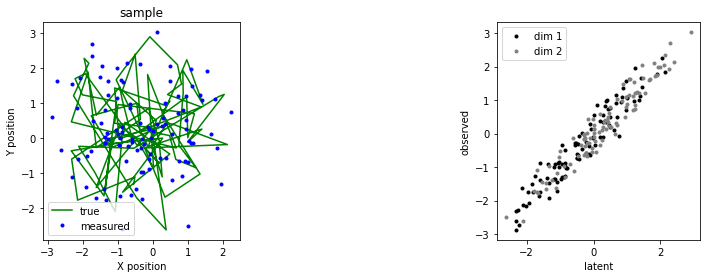

In [4]:
sampled_states, sampled_observations = kf.sample(100, initial_state=kf.initial_state_mean, random_state=np.random.RandomState(0))
sampled_states_impl, sampled_observations_impl = my_kf.sample(100, initial_state=kf.initial_state_mean, random_seed=0)
print('sampled states pykalman at t=2: ', sampled_states[2,:])
print('sampled states own implementation at t=2: ', sampled_states_impl[2,:])
fig = plot_kalman(sampled_states_impl[:,0],sampled_states_impl[:,1],sampled_observations_impl[:,0],sampled_observations_impl[:,1], title='sample');


### reduce observation noise
What do you expect should happen?

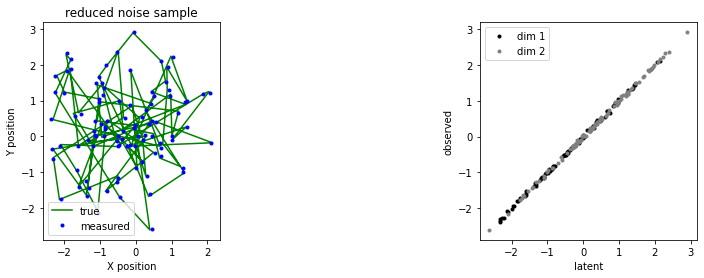

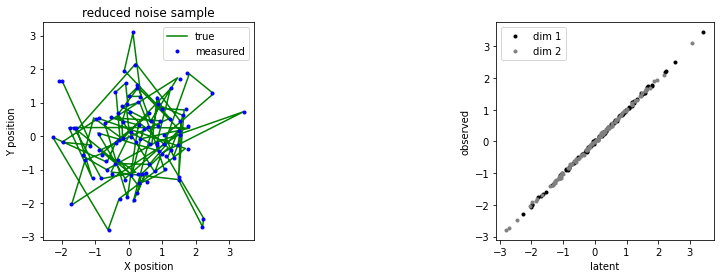

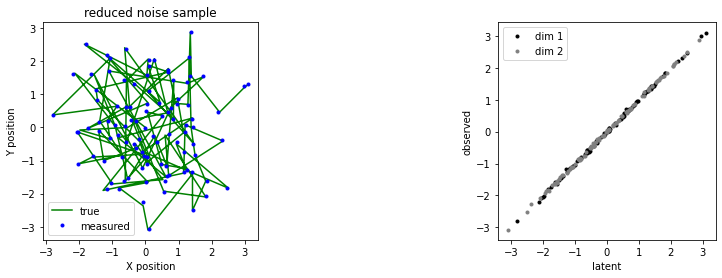

In [5]:
#### TODO ####
#### reduce observation noise ####
obscov_old = my_kf.observation_covariance.copy()
my_kf.observation_covariance = my_kf.observation_covariance*.01

# plot
for nn in range(3):
    sampled_states_impl, sampled_observations_impl = my_kf.sample(100, initial_state=kf.initial_state_mean, random_seed=nn)
    fig = plot_kalman(sampled_states_impl[:,0],sampled_states_impl[:,1],sampled_observations_impl[:,0],sampled_observations_impl[:,1], title='reduced noise sample');
    plt.axis('square');

### increase the respective temporal dyamics
What do you expect should happen?

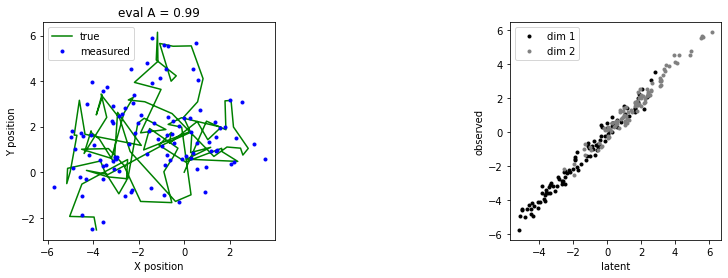

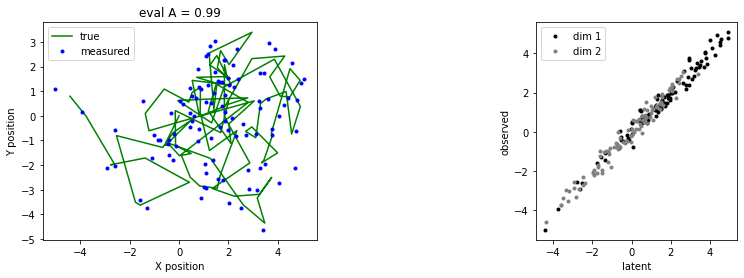

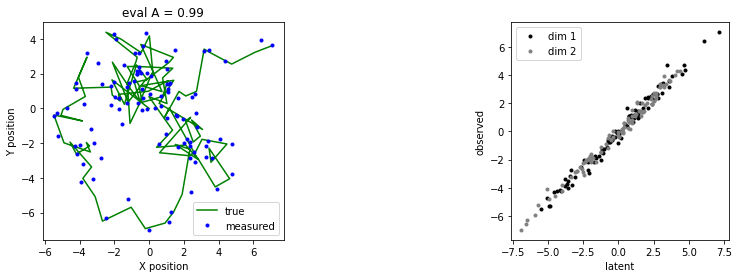

In [6]:
#### TODO ####
#### increase latent temporal dependency ####
my_kf.observation_covariance = obscov_old.copy()
my_kf.transition_matrices = np.eye(n_dim_state)*.9

# plot
for nn in range(3):
    sampled_states_impl, sampled_observations_impl = my_kf.sample(100, initial_state=kf.initial_state_mean, random_seed=nn)
    fig = plot_kalman(sampled_states_impl[:,0],sampled_states_impl[:,1],
                      sampled_observations_impl[:,0],sampled_observations_impl[:,1], title='eval A = '+np.str(.99));

# EM

### data to use

transition_matrices = [0.9 0.9], shape = (2,)

transition_covariance = [1. 1.], shape = (2,)

observation_covariance = [1. 1.], shape = (2,)

initial_state_covariance = [0.1 0.1], shape = (2,)

observation_matrices = [[1. 0.]
 [0. 1.]], shape = (2, 2)

initial_state_mean = [0. 0.], shape = (2,)



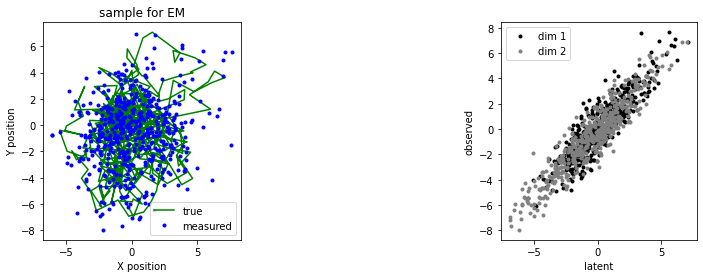

In [7]:
kf_GT = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
# set paramters
kf_GT.transition_matrices = np.eye(n_dim_state)*.9
kf_GT.transition_covariance = np.eye(n_dim_obs)
kf_GT.observation_matrices = np.eye(n_dim_state)
kf_GT.observation_covariance = np.eye(n_dim_obs)
kf_GT.initial_state_mean = np.zeros(n_dim_state)
kf_GT.initial_state_covariance = np.eye(n_dim_state)*.1
# import to your own kalman object
my_kf_GT = MyKalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
my_kf_GT.import_param(kf_GT)
# print the parameters
print_parameters(my_kf_GT, evals=True)


# sample
latent, data = kf_GT.sample(500, initial_state=kf_GT.initial_state_mean, random_state=np.random.RandomState(2))
_, _ = kf_GT.filter(data)
estlat,_ = kf_GT.smooth(data)
fig = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], title='sample for EM');


### Filtering
with known parameters

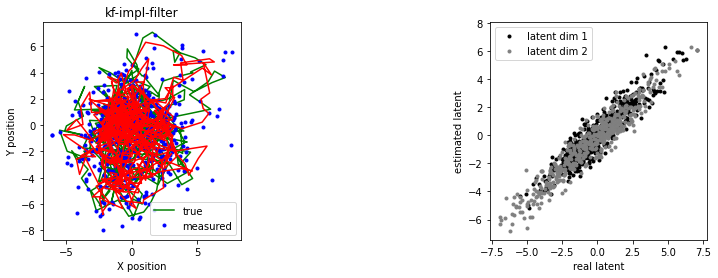

In [8]:
filtered_state_means_impl, filtered_state_covariances_impl = my_kf_GT.filter(data)
fig = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], filtered_state_means_impl[:,0], filtered_state_means_impl[:,1], "r-", title ="kf-impl-filter")
plt.axis('square');

### Smoothing
with known parameters

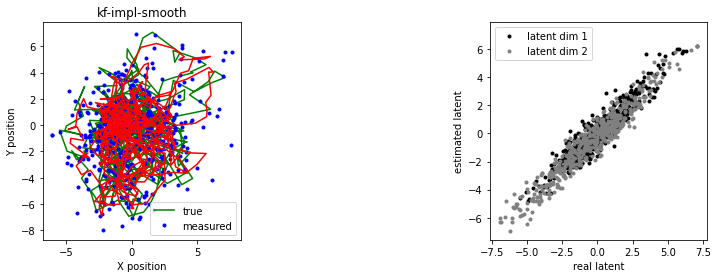

In [9]:
smoothed_state_means_impl, smoothed_state_covariances_impl = my_kf_GT.smooth(data)
fig = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], 
                  smoothed_state_means_impl[:,0], smoothed_state_means_impl[:,1], "r-", title="kf-impl-smooth")
plt.axis('square');

### run EM
to learn parameters (M-step)

In [10]:
np.random.seed(0)

iters = 10
# perturb starting parameters
kf = KalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1],
                 transition_matrices= np.eye(data.shape[1]) * 0.95,
                 observation_matrices= np.eye(data.shape[1])+np.random.randn(data.shape[1])*.1,
                 transition_covariance= np.eye(data.shape[1]),
                 observation_covariance = np.eye(data.shape[1]),
                 initial_state_mean=np.random.randn(data.shape[1]),
                  initial_state_covariance = np.eye(data.shape[1]),
                 em_vars = ['transition_matrices', 'observation_matrices','transition_covariance','observation_covariance',
                          'initial_state_mean', 'initial_state_covariance'])

my_kf = MyKalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1])
my_kf.import_param(kf)

kf.em(data, n_iter=iters)
my_kf.em(data, max_iter=iters)

print('           pykalman EM:')
print(' ')
print_parameters(kf, evals=True)
print('           own implementation EM:')
print(' ')
print_parameters(my_kf, evals=True)

           pykalman EM:
 
transition_matrices = [0.87764566 0.92906913], shape = (2,)

transition_covariance = [0.68854391 0.94375978], shape = (2,)

observation_covariance = [0.97845363 0.88969914], shape = (2,)

initial_state_covariance = [0.04314256 0.06181459], shape = (2,)

observation_matrices = [[1.12314164 0.02460226]
 [0.1431459  1.01994597]], shape = (2, 2)

initial_state_mean = [-1.20813372  0.51062271], shape = (2,)

           own implementation EM:
 
transition_matrices = [0.87703758 0.92961749], shape = (2,)

transition_covariance = [0.68882951 0.9447692 ], shape = (2,)

observation_covariance = [0.97828376 0.8894537 ], shape = (2,)

initial_state_covariance = [0.0431518  0.06180991], shape = (2,)

observation_matrices = [[1.12300893 0.02462427]
 [0.14317923 1.01988379]], shape = (2, 2)

initial_state_mean = [-1.20845467  0.5091462 ], shape = (2,)



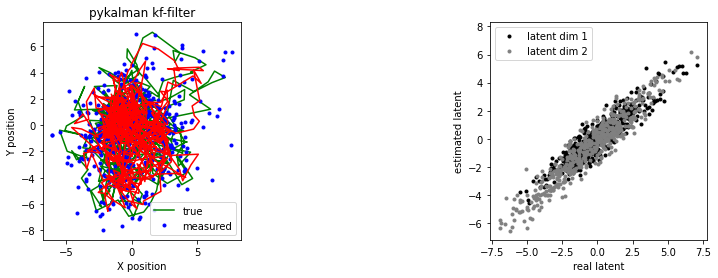

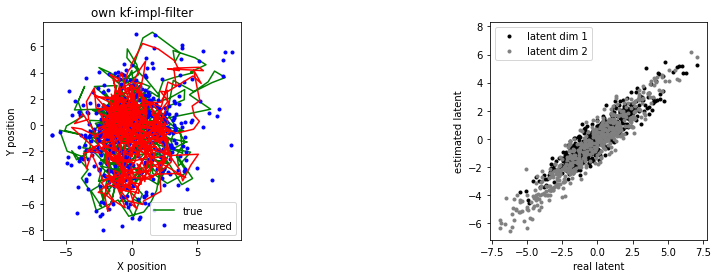

In [11]:
# compare the filter results
filtered_state_means, filtered_state_covariances = kf.filter(data)
filtered_state_means_impl, filtered_state_covariances_impl = my_kf.filter(data)
_ = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], 
                filtered_state_means[:,0], filtered_state_means[:,1], "r-", title="pykalman kf-filter")
plt.axis('square');
_ = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], 
                filtered_state_means_impl[:,0], filtered_state_means_impl[:,1], "r-", title="own kf-impl-filter")
plt.axis('square');

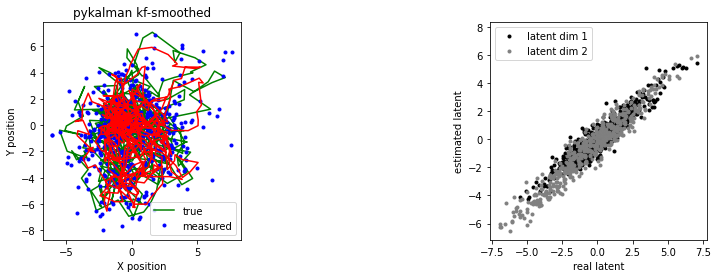

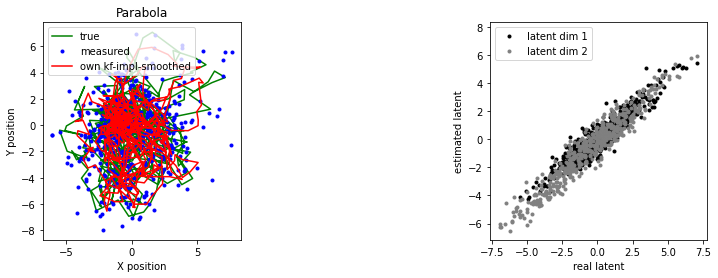

In [12]:
# compare the smooth results
smoothed_state_means, smoothed_state_covariances = kf.smooth(data)
smoothed_state_means_impl, smoothed_state_covariances_impl = my_kf.smooth(data)
_ = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], 
                smoothed_state_means[:,0], smoothed_state_means[:,1], "r-", title="pykalman kf-smoothed")
plt.axis('square');
_ = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], 
                smoothed_state_means_impl[:,0], smoothed_state_means_impl[:,1], "r-", "own kf-impl-smoothed")
plt.axis('square');

dict_keys(['transition_matrices', 'observation_matrices', 'transition_covariance', 'observation_covariance', 'transition_offsets', 'observation_offsets', 'initial_state_mean', 'initial_state_covariance', 'random_state', 'em_vars', 'n_dim_state', 'n_dim_obs'])


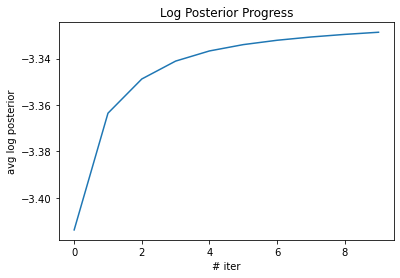

In [13]:
# visualize the change of avg log posterior
print(kf.__dict__.keys())
visualize_line_plot(my_kf.avg_em_log_posterior, "# iter", "avg log posterior", "Log Posterior Progress")

### Please turn in the code as a notebook AND as a pdf before 10/14/2019 11:55 pm. Please name your notebook netid.ipynb.

### Your work will be evaluated based on the code and plots. You don't need to write down your answers to these questions in the text blocks. 